# How to apply customized kernel using gpflow

In this code GPR is applied to predict the enery of 388 grain boundaries of olmsted database.

The pairwise distances are calculated based on the octonion package.

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary, positive
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter

set_default_float(np.float64)
set_default_summary_fmt("notebook")

plt.style.use("ggplot")
%matplotlib inline

Here I chose `n_train` = 100 of the grain boundaries randomly to start with. The total numbe rof gbs are `N` = 388. 

In [2]:
np.random.seed(10)
Y_all = np.loadtxt('./data/energy_olms.txt')
N = 388
n_train = 100

id_all = np.linspace(0,N-1, N)
# I chose first 100 gbs as training data set
id_train = np.random.choice(N, size=n_train, replace=False)
Y_train = Y_all[id_train].reshape(-1,1)
id_train = np.array(id_train, dtype=np.float64)
# I chose gbs from 100 to 297 as test set
id_test = id_all[~np.in1d(id_all,id_train)].reshape(-1,1)
id_train = id_train.reshape(-1,1)


Here I defined a new class for the our custom kernel named `GBKernel`. This kernel is inhereted from the `gpflow.kernels.Matern12`. Within this kernel the octonion distance is defined. The octonion distances are previously calculated using the Matlab code. In this function (`_octonion_dist`) the corresponding rows and vectors are extracted from the matlab output.

In [3]:
class GBKernel(gpflow.kernels.Matern12):
    """
    """

    def __init__(self, lengthscales=1.0):
        super().__init__(active_dims=[0])

    def _octonion_dist(self, X, X2):
        pd = np.loadtxt('./data/pd_olms.txt')
        xx = np.unique(np.concatenate((id_test, id_train), axis= 0)).reshape(-1,1)

        len_x = len(xx)
        dist = np.zeros((len_x, len_x))
        for i in range(len_x):
            for j in range(len_x):
                dist[i,j] = pd[int(xx[i]), int(xx[j])]
        return dist

#     @params_as_tensors
    def _scaled_square_dist(self, X, X2):
        """
    The Matern 1/2 kernel. Functions drawn from a GP with this kernel are not
    differentiable anywhere. The kernel equation is

    k(r) = σ² exp{-r}

    where:
    r  is the Euclidean distance between the input points, scaled by the lengthscales parameter ℓ.
    σ² is the variance parameter
    """
        if X2 is None:
            X2 = X
#         dist = tf.square(self._haversine_dist(X, X2) / self.lengthscales)
#         dist = self.variance * tf.exp(-0.5 * self._octonion_dist(X, X2))
        dist = self.variance * tf.exp(-self._octonion_dist(X, X2))
        return dist

The GPR model is created and optimized.

In [15]:
m = gpflow.models.GPR((id_train, Y_train), kernel=GBKernel())

opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)
mean, var = m.predict_y(id_test)


Here I plotted the results.

Text(0, 0.5, 'energy')

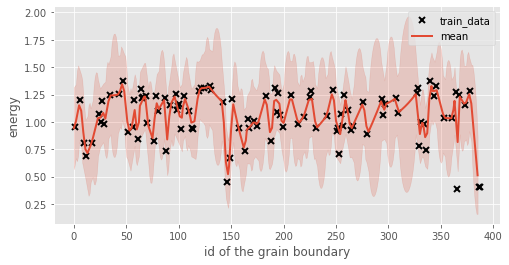

In [23]:
## plot
plt.figure(figsize=(8, 4))
plt.plot(id_train, Y_train, "kx", mew=2, label='train_data')
plt.plot(id_test, mean, "C0", lw=2, label='mean')

plt.fill_between(
    id_test[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2
)
plt.legend()
plt.xlabel('id of the grain boundary')
plt.ylabel('energy')

In [6]:


n_max = 5
var_np  = var.numpy().reshape(-1)
new_gb_id = (-var_np).argsort()[:n_max]
print('The gbs with highest variance have the ids:\n')
print(new_gb_id)



The gbs with highest variance have the ids:

[236 235 237 234 238]


Text(0, 0.5, 'Actual Energy values')

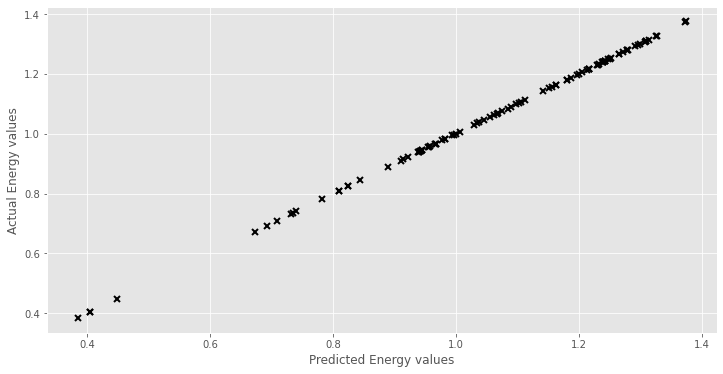

In [9]:
m = gpflow.models.GPR((id_train, Y_train), kernel=GBKernel())

opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)
mean, var = m.predict_y(id_train)
plt.figure(figsize=(12, 6))
plt.plot(mean, Y_train, "kx", mew=2)
plt.xlabel('Predicted Energy values')
plt.ylabel('Actual Energy values')

In [24]:
id_test.shape

(288, 1)

In [25]:
var_np.max()

0.1656769228228588